# 2023 Day 10

https://adventofcode.com/2023/day/10

https://adventofcode.com/2023/day/10/input

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
inp = open('input-10.txt').read()
# print(inp)

In [3]:
test = """-L|F7
7S-7|
L|7||
-L-J|
L|-JF"""
print(test)

-L|F7
7S-7|
L|7||
-L-J|
L|-JF


## Part 1

In [4]:
east, west = (0, 1), (0, -1)
north, south = (-1, 0), (1, 0)

def rev(dxdy):
    dx, dy = dxdy
    return (-dx, -dy)

def vadd(xy, dxdy):
    x, y = xy
    dx, dy = dxdy
    return(x + dx, y + dy)

def vsub(va, vb):
    xa, ya = va
    xb, yb = vb
    return (xa - xb, ya - yb)

def vavg(va, vb):
    xa, ya = va
    xb, yb = vb
    return ((xa + xb) / 2, (ya + yb) / 2)

allowed_exit_by_cur = {
    'S': [north, east, south, west],
    '-': [east, west],
    '|': [north, south],
    '7': [south, west],
    'F': [south, east],
    'J': [north, west],
    'L': [north, east],
}

allowed_entry_by_dest = {k: list(map(rev, v)) for (k, v) in allowed_exit_by_cur.items()}

poss_chars = '-|7FJLS'
assert not set(poss_chars) - set(allowed_exit_by_cur)

display(allowed_exit_by_cur)
print()
display(allowed_entry_by_dest)

{'S': [(-1, 0), (0, 1), (1, 0), (0, -1)],
 '-': [(0, 1), (0, -1)],
 '|': [(-1, 0), (1, 0)],
 '7': [(1, 0), (0, -1)],
 'F': [(1, 0), (0, 1)],
 'J': [(-1, 0), (0, -1)],
 'L': [(-1, 0), (0, 1)]}

{'S': [(1, 0), (0, -1), (-1, 0), (0, 1)],
 '-': [(0, -1), (0, 1)],
 '|': [(1, 0), (-1, 0)],
 '7': [(-1, 0), (0, 1)],
 'F': [(-1, 0), (0, -1)],
 'J': [(1, 0), (0, 1)],
 'L': [(1, 0), (0, -1)]}

In [5]:
def parse_nodes(text):
    return {
        (irow, jcol): c
        for (irow, line) in enumerate(text.split('\n'))
        for (jcol, c) in enumerate(line)
    }

def find_start(nodes):
    return [xy for (xy, c) in nodes.items() if c == 'S'][0]

def step_next(chain, nodes):
    loc = chain[-1]
    cur = nodes[loc]
    poss_dxdy = allowed_exit_by_cur[cur]
    # print(f'{chain[-2:]=}\n  {cur} += {poss_dxdy}')
    # print()
    for dxdy in poss_dxdy:
        new_loc = vadd(loc, dxdy)
        if len(chain) >= 2 and new_loc == chain[-2]:
            continue
        dest = nodes[new_loc]
        if dest == '.':
            continue
        if dxdy in allowed_entry_by_dest[dest]:
            return chain + [new_loc]
        
        
def text_to_nodes_and_chain(text, maxn=10**6):
    nodes = parse_nodes(text)
    loc = start = find_start(nodes)
    chain = [start]
    for i in range(maxn):
        chain = step_next(chain, nodes)
        if chain[-1] == start:
            break
    return nodes, chain

In [6]:
nodes = parse_nodes(test)
print(nodes)

{(0, 0): '-', (0, 1): 'L', (0, 2): '|', (0, 3): 'F', (0, 4): '7', (1, 0): '7', (1, 1): 'S', (1, 2): '-', (1, 3): '7', (1, 4): '|', (2, 0): 'L', (2, 1): '|', (2, 2): '7', (2, 3): '|', (2, 4): '|', (3, 0): '-', (3, 1): 'L', (3, 2): '-', (3, 3): 'J', (3, 4): '|', (4, 0): 'L', (4, 1): '|', (4, 2): '-', (4, 3): 'J', (4, 4): 'F'}


In [7]:
start = find_start(nodes)
start

(1, 1)

In [8]:
nodes, chain = text_to_nodes_and_chain(test)
print(chain)
len(chain) // 2

[(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1)]


4

In [9]:
nodes, chain = text_to_nodes_and_chain(inp)
len(chain) // 2

6786

## Part 2

In [10]:
def get_wind_number(testpt, chain):
    # https://towardsdatascience.com/is-the-point-inside-the-polygon-574b86472119
    # https://wrfranklin.org/Research/Short_Notes/pnpoly.html
    chain1 = chain[:-1]
    n = len(chain1)
    wn = 0
    for (i, loc) in enumerate(chain1):
        if loc[1] != testpt[1]:
            continue

        loc_prev = chain1[(i - 1) % n]
        loc_next = chain1[(i + 1) % n]
        delta1 = vsub(loc, loc_prev)
        delta2 = vsub(loc_next, loc)

        for delta in (delta1, delta2):
            if not delta[1]:
                continue
            is_right = np.sign(delta[1]) == np.sign(testpt[0] - loc[0])
            wn += 1 if is_right else -1

        # print(loc, delta, wn)
    return wn

def find_inside(nodes, chain):
    insides = []
    wns = {}
    for testpt in nodes:
        if testpt in chain:
            continue
        wn = get_wind_number(testpt, chain)
        if wn:
            insides.append(testpt)
            wns[testpt] = wn
    return insides, wns

In [11]:
test3 = """.F----7F7F7F7F-7....
.|F--7||||||||FJ....
.||.FJ||||||||L7....
FJL7L7LJLJ||LJ.L-7..
L--J.L7...LJS7F-7L7.
....F-J..F7FJ|L7L7L7
....L7.F7||L7|.L7L7|
.....|FJLJ|FJ|F7|.LJ
....FJL-7.||.||||...
....L---J.LJ.LJLJ..."""

In [12]:
nodes, chain = text_to_nodes_and_chain(test3)
insides, wns = find_inside(nodes, chain)

In [13]:
wns

{(3, 14): -4,
 (4, 7): -4,
 (4, 8): -4,
 (4, 9): -4,
 (5, 7): -4,
 (5, 8): -4,
 (6, 6): -4,
 (6, 14): -4}

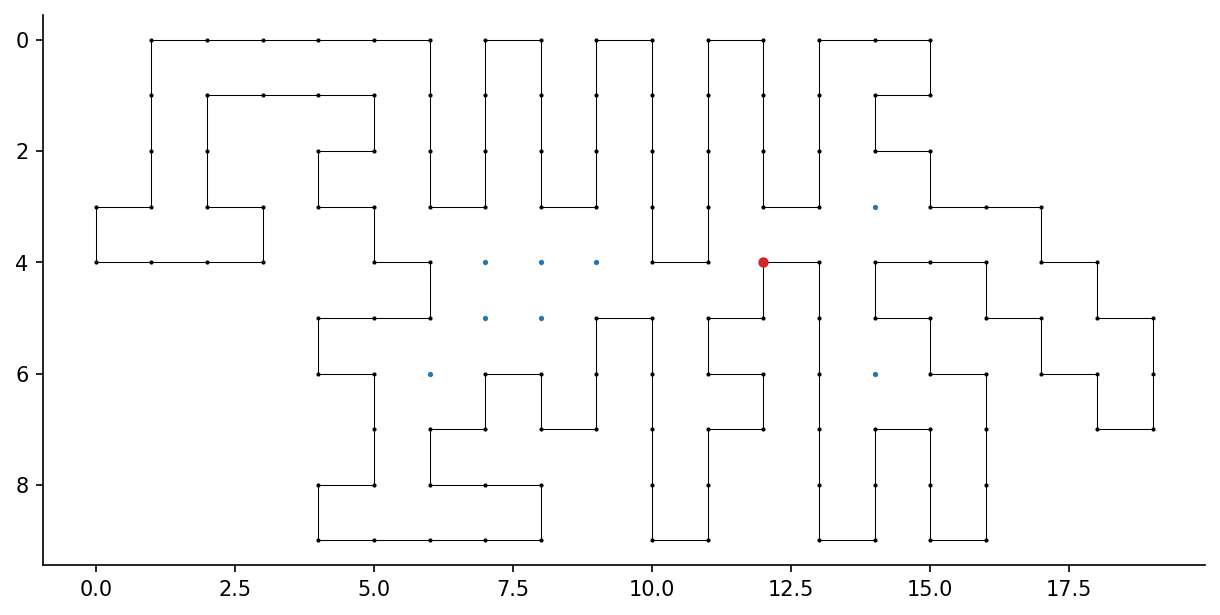

In [14]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
y, x = np.transpose(chain)
ax.plot(x, y, 'k.-', ms=2, lw=.5)
ax.plot(x[0], y[0], '.', color='C3', ms=8)
y, x = np.transpose(insides)
ax.plot(x, y, '.', color='C0', ms=3)
ax.set(aspect='equal', ylim=reversed(ax.get_ylim()));

### Finally...

In [15]:
nodes, chain = text_to_nodes_and_chain(inp)
insides, wns = find_inside(nodes, chain)

In [16]:
len(insides)

495

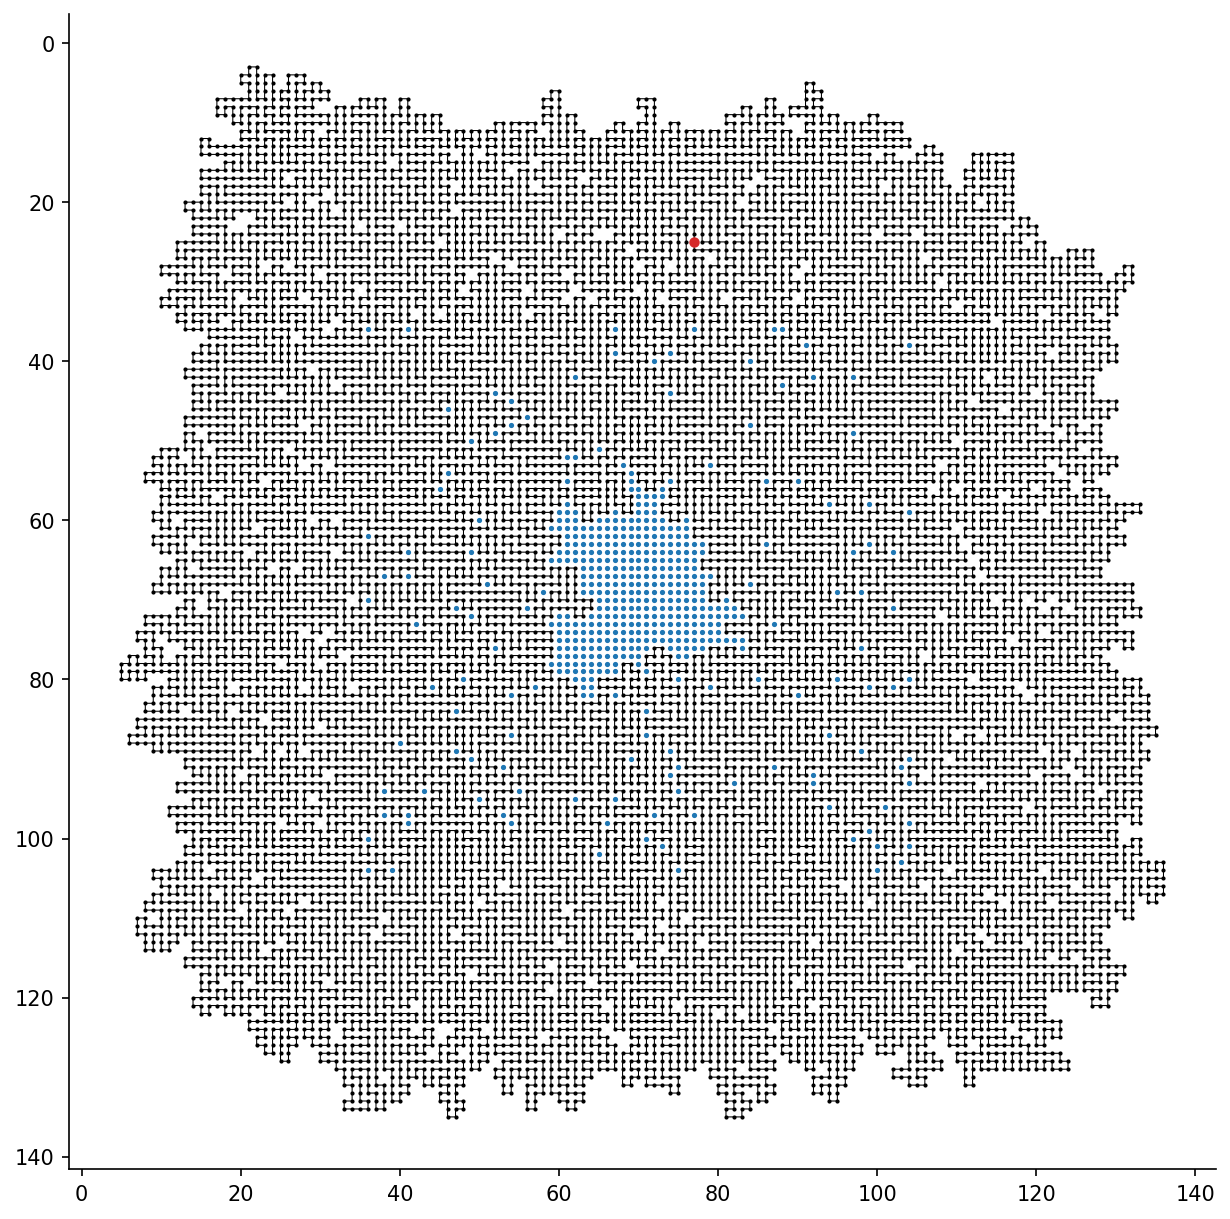

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
y, x = np.transpose(chain)
ax.plot(x, y, 'k.-', ms=2, lw=.5)
ax.plot(x[0], y[0], '.', color='C3', ms=8)
y, x = np.transpose(insides)
ax.plot(x, y, '.', color='C0', ms=3)
ax.set(aspect='equal', ylim=reversed(ax.get_ylim()));